# 1) Importing Libraries, Data Loading

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess

from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error

from pmdarima.arima import auto_arima
from pmdarima import pipeline
from pmdarima import model_selection
from pmdarima import preprocessing as ppc
from pmdarima import arima

from prophet import Prophet 

df_train = pd.read_csv(r'/Users/niccolocomar/Documents/Econometria/Data Science/Inventory Management/Store Item Demand Forecasting Challenge/demand-forecasting-kernels-only/train.csv')
df_test = pd.read_csv(r'/Users/niccolocomar/Documents/Econometria/Data Science/Inventory Management/Store Item Demand Forecasting Challenge/demand-forecasting-kernels-only/test.csv')

# 2) Exploratory Data Analysis

In [2]:
def explore_dataset(dataset, title):
    # Title of the dataset
    print(f"\033[1m{title}\033[0m\n")  # Using ANSI escape codes for bold text
    # Displaying the first few rows of the dataset
    print("Head of the dataset:")
    print(dataset.head())
    # Displaying data types
    print("Data types:")
    print(dataset.dtypes, end='\n\n')
    # Displaying dataset information
    print("Dataset information:")
    print(dataset.info(), end='\n\n')
    # Displaying summary statistics
    print("Summary statistics:")
    print(dataset.describe().T, end='\n\n')
    # Displaying the shape of the dataset
    print("Shape of the dataset:")
    print(dataset.shape, end='\n\n')
    # Displaying the number of missing values
    print("Number of missing values:")
    print(dataset.isnull().sum(), end='\n\n')
    # Displaying the number of duplicated rows
    print("Number of duplicated rows:")
    print(dataset.duplicated().sum(), end='\n\n')


In [3]:
explore_dataset(df_train, 'Training')

Training

Head of the dataset:
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
Data types:
date     object
store     int64
item      int64
sales     int64
dtype: object

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None

Summary statistics:
          count       mean        std  min   25%   50%   75%    max
store  913000.0   5.500000   2.872283  1.0   3.0   5.5   8.0   10.0
item   913000.0  25.500000  14.430878  1.0  13.0  25.5  38.0   50.0
sales  913000.0  52.250287  28.801144  0

In [4]:
explore_dataset(df_test, 'Testing')

Testing

Head of the dataset:
   id        date  store  item
0   0  2018-01-01      1     1
1   1  2018-01-02      1     1
2   2  2018-01-03      1     1
3   3  2018-01-04      1     1
4   4  2018-01-05      1     1
Data types:
id        int64
date     object
store     int64
item      int64
dtype: object

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      45000 non-null  int64 
 1   date    45000 non-null  object
 2   store   45000 non-null  int64 
 3   item    45000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.4+ MB
None

Summary statistics:
         count     mean           std  min       25%      50%       75%  \
id     45000.0  22499.5  12990.525394  0.0  11249.75  22499.5  33749.25   
store  45000.0      5.5      2.872313  1.0      3.00      5.5      8.00   
item   45000.0     25.5     14.431030  1.0     

In [5]:
#Converting 'date' from object to datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

**Analysis per store**

In [6]:
df_train['store'].nunique()

10

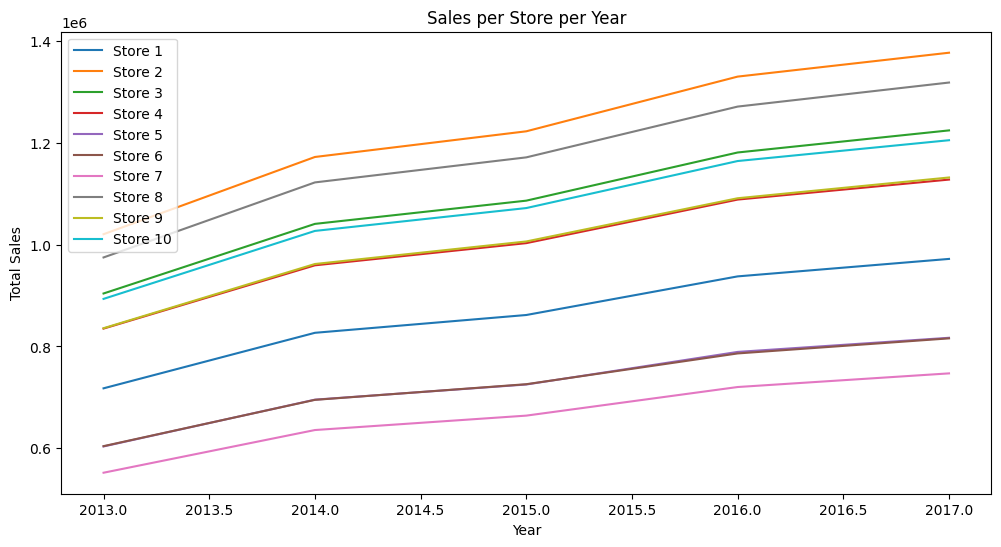

In [7]:
# Extract the 'year' from the 'date' column
df_train['year'] = df_train['date'].dt.year
df_test['year'] = df_test['date'].dt.year

# Group by 'year', 'store', and sum the 'sales'
sales_per_year_store = df_train.groupby(['year', 'store'])['sales'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))

for store in sales_per_year_store['store'].unique():
    store_data = sales_per_year_store[sales_per_year_store['store'] == store]
    plt.plot(store_data['year'], store_data['sales'], label=f'Store {store}')

plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Sales per Store per Year')
plt.legend()
plt.show()

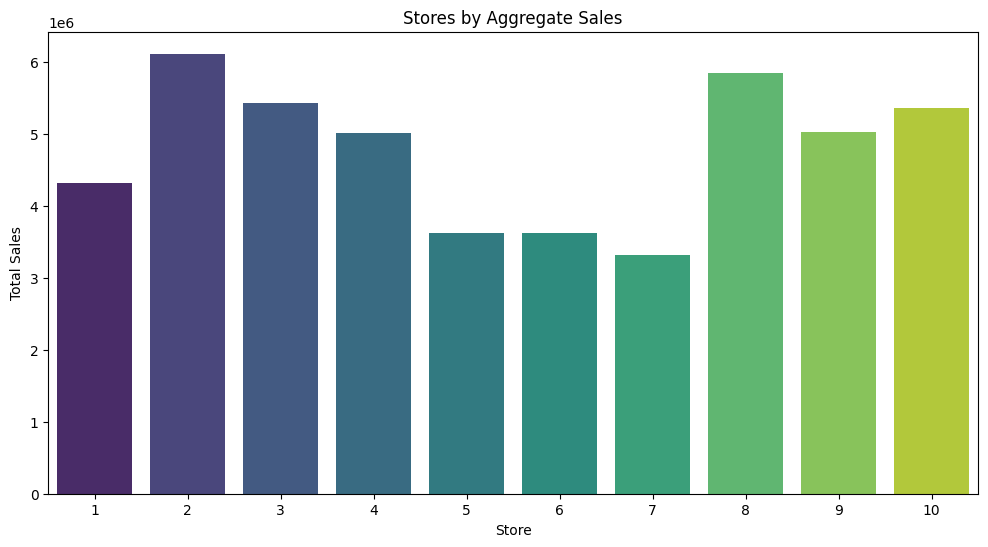

In [8]:
# Aggregate sales per store
sales_per_store = df_train.groupby('store')['sales'].sum().reset_index()

# Plot aggregate sales per store
plt.figure(figsize=(12, 6))
stores_by_aggsales = sales_per_store.nlargest(20, 'sales')
sns.barplot(x='store', y='sales', data=stores_by_aggsales, palette='viridis')
plt.title('Stores by Aggregate Sales')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.show()

**Analysis per item**

In [9]:
df_train['item'].nunique() 

50

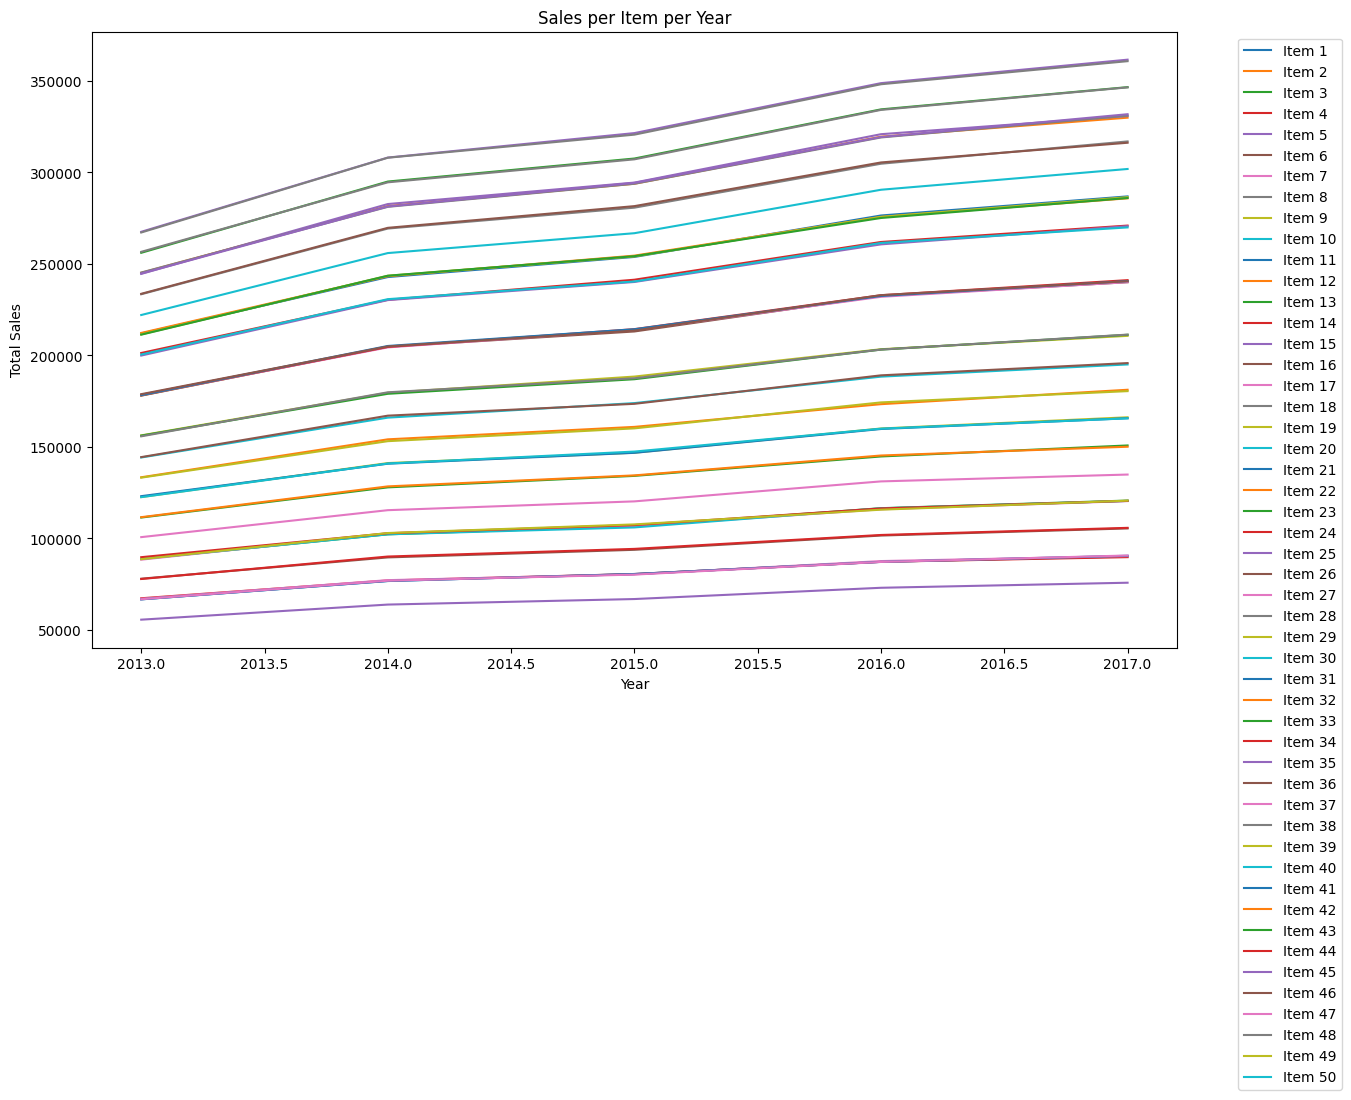

In [10]:
# Group by 'year', 'item', and sum the 'sales'
sales_per_year_item = df_train.groupby(['year', 'item'])['sales'].sum().reset_index()

# Plotting
plt.figure(figsize=(14, 8))

for item in sales_per_year_item['item'].unique():
    store_item = sales_per_year_item[sales_per_year_item['item'] == item]
    plt.plot(store_item['year'], store_item['sales'], label=f'Item {item}')

plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Sales per Item per Year')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

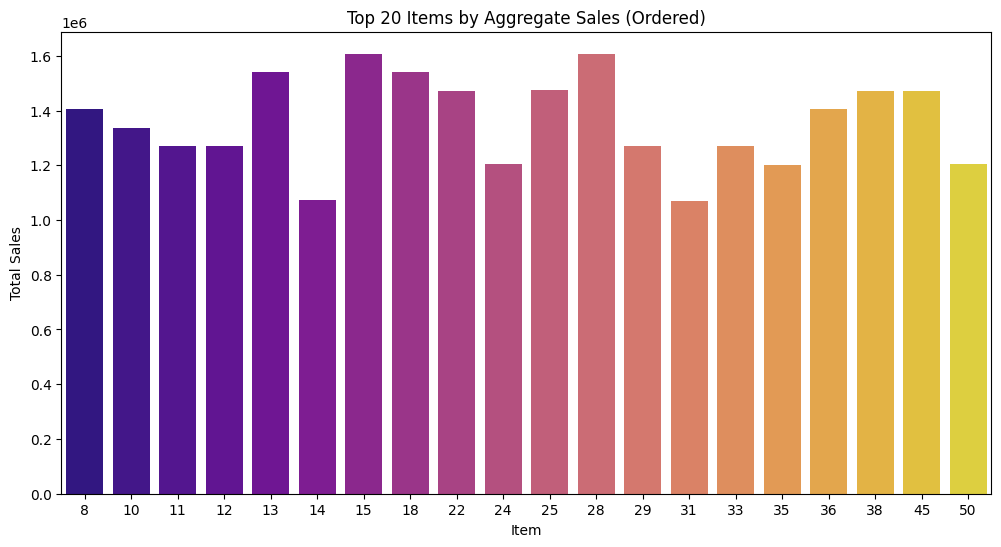

In [11]:
# Aggregate sales per item
sales_per_item = df_train.groupby('item')['sales'].sum().reset_index()

# Sort items by sales in descending order
sorted_items = sales_per_item.sort_values(by='sales', ascending=False)

# Plot top 20 items
plt.figure(figsize=(12, 6))
top_20_items = sorted_items.head(20)
sns.barplot(x='item', y='sales', data=top_20_items, palette='plasma')
plt.title('Top 20 Items by Aggregate Sales (Ordered)')
plt.xlabel('Item')
plt.ylabel('Total Sales')
plt.show()

We see that:

- we have sales from 10 stores,
- 50 different items have been sold,
- yearly sales by store and yearly sales by item have very similar trends over time.

**Sales through time**

In [12]:
#Aggregate sales per store through time (per date)
df_train_agg_store = df_train.groupby(['date', 'store'])['sales'].sum().reset_index()
#df_train_agg_store.sort_values('date', inplace=True)
df_train_agg_store

,date,store,sales
0,2013-01-01,1,1316
1,2013-01-01,2,1742
2,2013-01-01,3,1588
3,2013-01-01,4,1423
4,2013-01-01,5,1032
...,...,...,...
18255,2017-12-31,6,2009
18256,2017-12-31,7,1831
18257,2017-12-31,8,3205
18258,2017-12-31,9,2774


In [13]:
#Aggregate sales per item through time (per date)
df_train_agg_item = df_train.groupby(['date', 'item'])['sales'].sum().reset_index()
#df_train_agg_item.sort_values('date', inplace=True)
df_train_agg_item

,date,item,sales
0,2013-01-01,1,133
1,2013-01-01,2,327
2,2013-01-01,3,172
3,2013-01-01,4,102
4,2013-01-01,5,83
...,...,...,...
91295,2017-12-31,46,605
91296,2017-12-31,47,211
91297,2017-12-31,48,494
91298,2017-12-31,49,285


In [14]:
# Find the store with the most sales and the corresponding sales
most_sold_store = df_train_agg_store.groupby('store')['sales'].sum().idxmax()
most_sold_store_sales = df_train_agg_store.groupby('store')['sales'].sum().max()

# Find the item with the most sales and the corresponding sales
most_sold_item = df_train_agg_item.groupby('item')['sales'].sum().idxmax()
most_sold_item_sales = df_train_agg_item.groupby('item')['sales'].sum().max()

# Find the store with the least sales and the corresponding sales
least_sold_store = df_train_agg_store.groupby('store')['sales'].sum().idxmin()
least_sold_store_sales = df_train_agg_store.groupby('store')['sales'].sum().min()

# Find the item with the least sales and the corresponding sales
least_sold_item = df_train_agg_item.groupby('item')['sales'].sum().idxmin()
least_sold_item_sales = df_train_agg_item.groupby('item')['sales'].sum().min()

# Display the results
print("The store that sold the most is number", most_sold_store, "with total aggregate Sales", most_sold_store_sales)
print("Most Sold Item is number", most_sold_item, "with total aggregate Sales", most_sold_item_sales)
print("The store that sold the least is number", least_sold_store, "with total aggregate Sales", least_sold_store_sales)
print("Least Sold Item is number", least_sold_item, "with total aggregate Sales", least_sold_item_sales)

The store that sold the most is number 2 with total aggregate Sales 6120128
Most Sold Item is number 15 with total aggregate Sales 1607442
The store that sold the least is number 7 with total aggregate Sales 3320009
Least Sold Item is number 5 with total aggregate Sales 335230


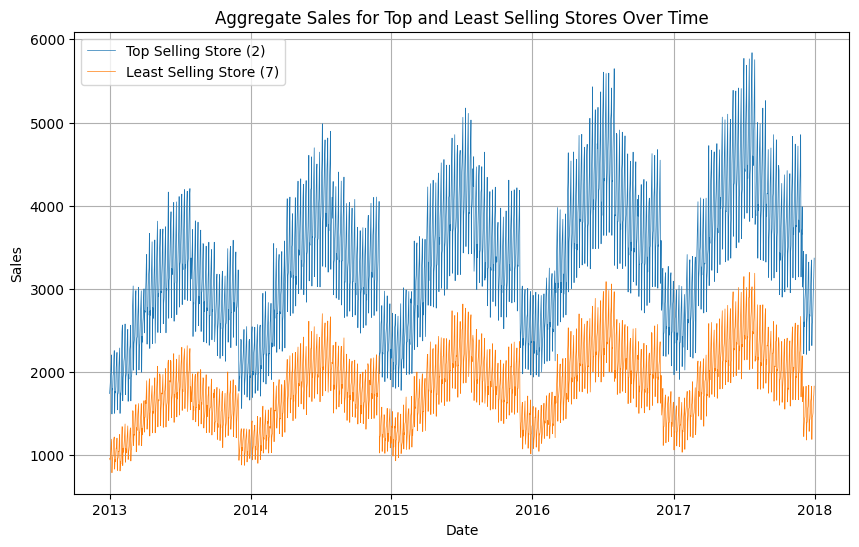

In [15]:
#Aggregate sales per date, according to the top selling store (number 2)
sales_store_2 = df_train_agg_store[df_train_agg_store['store'] == 2]
#Aggregate sales per date, according to the least selling store (number 7)
sales_store_7 = df_train_agg_store[df_train_agg_store['store'] == 7]
#Aggregate sales per date, according to the top selling item (number 15)
sales_item_15 = df_train_agg_item[df_train_agg_item['item'] == 15]
#Aggregate sales per date, according to the least selling item (number 5)
sales_item_5 = df_train_agg_item[df_train_agg_item['item'] == 5]


# Plotting for top selling store (number 2) and least selling store (number 7)
plt.figure(figsize=(10, 6))
plt.plot(sales_store_2['date'], sales_store_2['sales'], label='Top Selling Store (2)', linewidth=0.5)
plt.plot(sales_store_7['date'], sales_store_7['sales'], label='Least Selling Store (7)', linewidth=0.5)
plt.title('Aggregate Sales for Top and Least Selling Stores Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

Store number 2 is the one with most daily sales over the observed timeframe.
We can see the very similar trend in time with daily sales for the elast selling store, being store number 7.

We can appreciate that also plotting total daily sales per store over time (below).

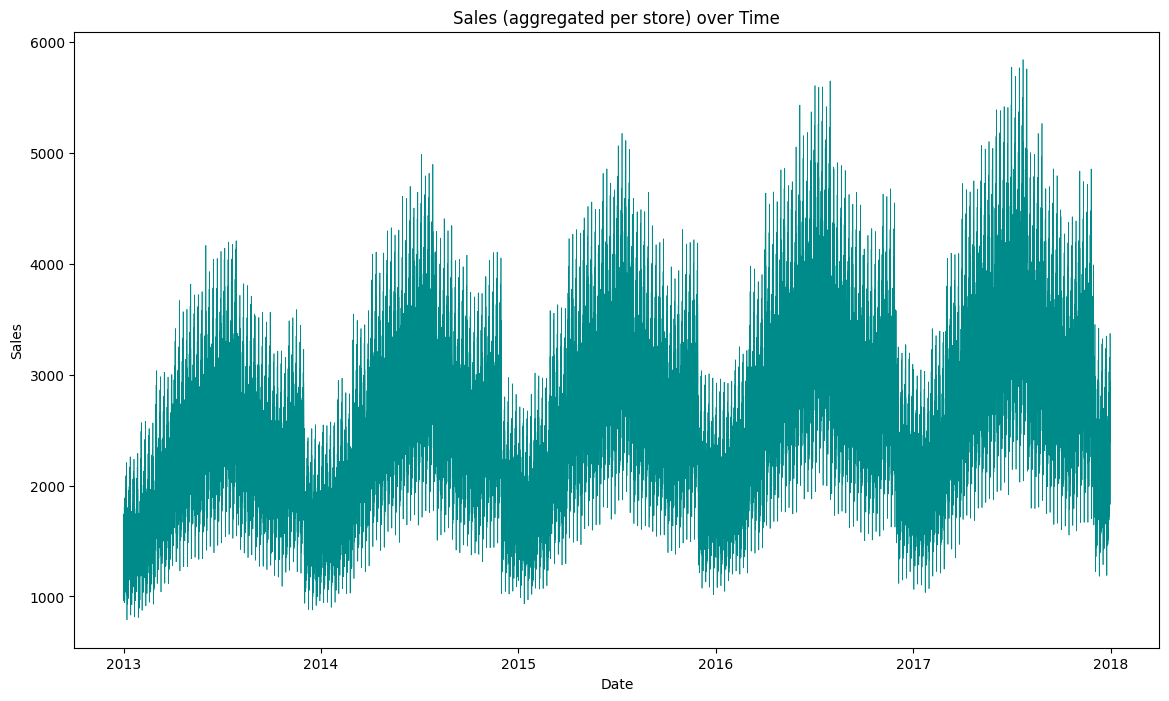

In [16]:
#Total daily sales, aggregated per store
plt.figure(figsize=(14, 8))
plt.plot(df_train_agg_store['date'], df_train_agg_store['sales'], color='darkcyan', linewidth=0.5)
plt.title('Sales (aggregated per store) over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

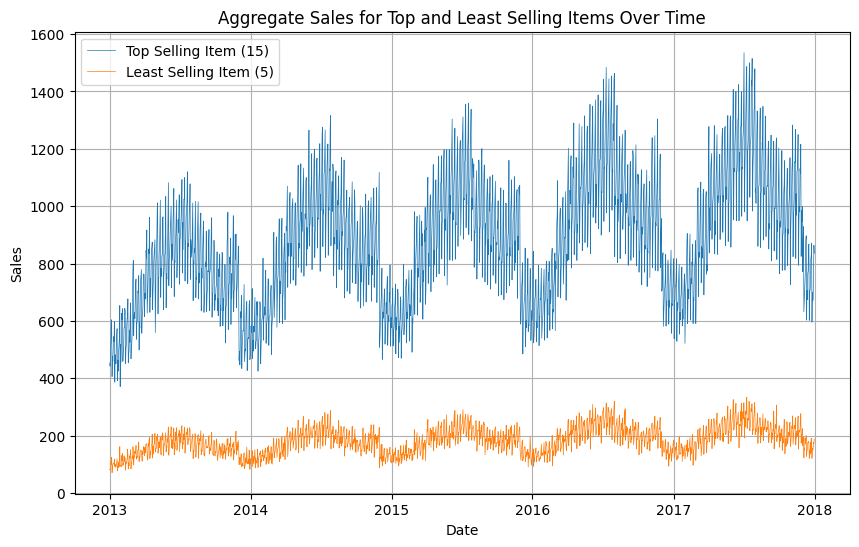

In [17]:
# Plotting for top selling item (number 15) and least selling item (number 5)
plt.figure(figsize=(10, 6))
plt.plot(sales_item_15['date'], sales_item_15['sales'], label='Top Selling Item (15)', linewidth=0.5)
plt.plot(sales_item_5['date'], sales_item_5['sales'], label='Least Selling Item (5)', linewidth=0.5)
plt.title('Aggregate Sales for Top and Least Selling Items Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

As we have seen above for daily stores sales, there are similar trends over time for daily sales for the top-selling product (item 15) and for the least-selling product (item 5).

We have a strong visual confirmation of presence of yearly trends (sales seem to increase year by year) and seasonality (repeated, cyclical pattern visible within every year). We can check it in the below plot, showing aggregate daily sales per item.


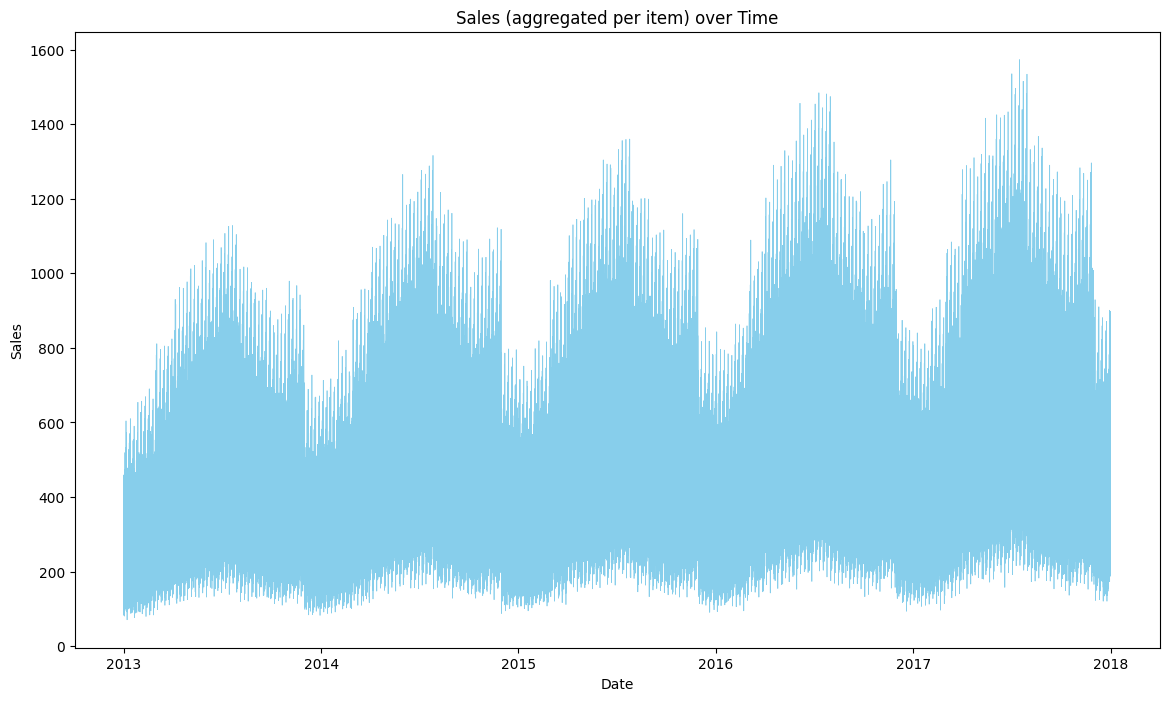

In [18]:
#Total daily sales, aggregated per item
plt.figure(figsize=(14, 8))
plt.plot(df_train_agg_item['date'], df_train_agg_item['sales'], color='skyblue', linewidth=0.5)
plt.title('Sales (aggregated per item) over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

Bottom line: there is an evident presence of trends/stagionality within the sales data, either if aggregated at item level, either if aggregated at store level.


# 4) Prophet modeling evaluation 

In [19]:
#Converting ‘date’ and ‘sales’ (date and target column) to Prophet desired column names ‘ds’ and ‘y’
df_train_agg_item_pr = df_train_agg_item.rename(columns={'date': 'ds', 'sales': 'y'})
df_train_agg_item_pr

,ds,item,y
0,2013-01-01,1,133
1,2013-01-01,2,327
2,2013-01-01,3,172
3,2013-01-01,4,102
4,2013-01-01,5,83
...,...,...,...
91295,2017-12-31,46,605
91296,2017-12-31,47,211
91297,2017-12-31,48,494
91298,2017-12-31,49,285


We use a portion of the total aggregate sales per item dataset (df_train_agg_item_pr’) only for item 1, as apparently all products follow the very same trend and seasonal patterns through time.

We will hence split this sub-dataset into train/test sets so we can train the Prophet model, and evaluate its performance.

Again, if the model works fine, we can try and forecast the sales for the next 90 days (timeframe for 'df_test').

In [20]:
# Filtering data for item 1
df_train_agg_item1 = df_train_agg_item_pr[df_train_agg_item_pr['item'] == 1].reset_index(drop=True)
df_train_agg_item1

,ds,item,y
0,2013-01-01,1,133
1,2013-01-02,1,99
2,2013-01-03,1,127
3,2013-01-04,1,145
4,2013-01-05,1,149
...,...,...,...
1821,2017-12-27,1,154
1822,2017-12-28,1,178
1823,2017-12-29,1,207
1824,2017-12-30,1,236


**Train/test split on df_train_agg_item1**


In [21]:
from datetime import timedelta

#Calculating how many days are in the 'data' column
num_days = (df_train_agg_item1['ds'].max() - df_train_agg_item1['ds'].min()).days + 1
print(f"Number of days between the min and max dates: {num_days} days")

Number of days between the min and max dates: 1826 days


In [23]:
#Calculating the date which marks the 80% split
split_date = df_train_agg_item1['ds'].min() + timedelta(days=int(0.8 * num_days))
split_date

Timestamp('2016-12-31 00:00:00')

In [25]:
#Splitting train/test sets for 'df_train_agg_item1' dataset using October, 31st 2016 as split date
train = df_train_agg_item1[df_train_agg_item1['ds'] <= split_date].copy()
test = df_train_agg_item1[df_train_agg_item1['ds'] > split_date].copy()
train.shape, test.shape

((1461, 3), (365, 3))

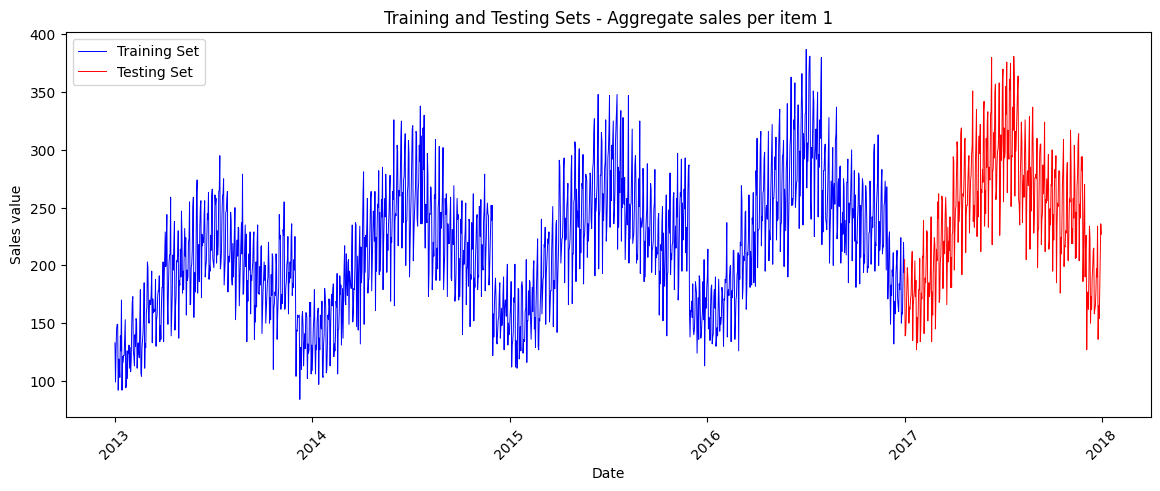

In [33]:
plt.figure(figsize=(14, 5))
plt.plot(train['ds'], train['y'], label='Training Set', color='blue', linewidth=0.7)
plt.plot(test['ds'], test['y'], label='Testing Set', color='red', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('Sales value')
plt.title('Training and Testing Sets - Aggregate sales per item 1')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Prophet model training**

In [27]:
#Training the Prophet model
m_train = Prophet()
m_train.fit(train)

14:49:06 - cmdstanpy - INFO - Chain [1] start processing
14:49:07 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
#Predictions using the testing dataset
forecast_test = m_train.predict(test)
forecast_test

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01,247.141240,204.382909,249.566243,247.141240,247.141240,-20.590554,-20.590554,-20.590554,40.001262,40.001262,40.001262,-60.591816,-60.591816,-60.591816,0.0,0.0,0.0,226.550687
1,2017-01-02,247.191226,120.503600,164.826663,247.191226,247.191226,-104.783218,-104.783218,-104.783218,-44.004367,-44.004367,-44.004367,-60.778851,-60.778851,-60.778851,0.0,0.0,0.0,142.408007
2,2017-01-03,247.241211,148.739029,192.395145,247.241211,247.241211,-77.370484,-77.370484,-77.370484,-16.330962,-16.330962,-16.330962,-61.039522,-61.039522,-61.039522,0.0,0.0,0.0,169.870727
3,2017-01-04,247.291196,146.914691,193.789184,247.291196,247.291196,-76.684830,-76.684830,-76.684830,-15.321743,-15.321743,-15.321743,-61.363087,-61.363087,-61.363087,0.0,0.0,0.0,170.606366
4,2017-01-05,247.341181,159.623919,205.682882,247.341181,247.341181,-64.838863,-64.838863,-64.838863,-3.101898,-3.101898,-3.101898,-61.736965,-61.736965,-61.736965,0.0,0.0,0.0,182.502318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2017-12-27,265.135919,165.582041,213.124598,256.822411,273.890650,-76.351390,-76.351390,-76.351390,-15.321743,-15.321743,-15.321743,-61.029647,-61.029647,-61.029647,0.0,0.0,0.0,188.784529
361,2017-12-28,265.185905,174.829897,225.058674,256.829620,273.982257,-63.862542,-63.862542,-63.862542,-3.101898,-3.101898,-3.101898,-60.760644,-60.760644,-60.760644,0.0,0.0,0.0,201.323363
362,2017-12-29,265.235890,192.476352,241.299365,256.835483,274.073864,-48.055553,-48.055553,-48.055553,12.520003,12.520003,12.520003,-60.575556,-60.575556,-60.575556,0.0,0.0,0.0,217.180337
363,2017-12-30,265.285875,208.410827,255.961414,256.841345,274.165471,-34.241844,-34.241844,-34.241844,26.237705,26.237705,26.237705,-60.479550,-60.479550,-60.479550,0.0,0.0,0.0,231.044031


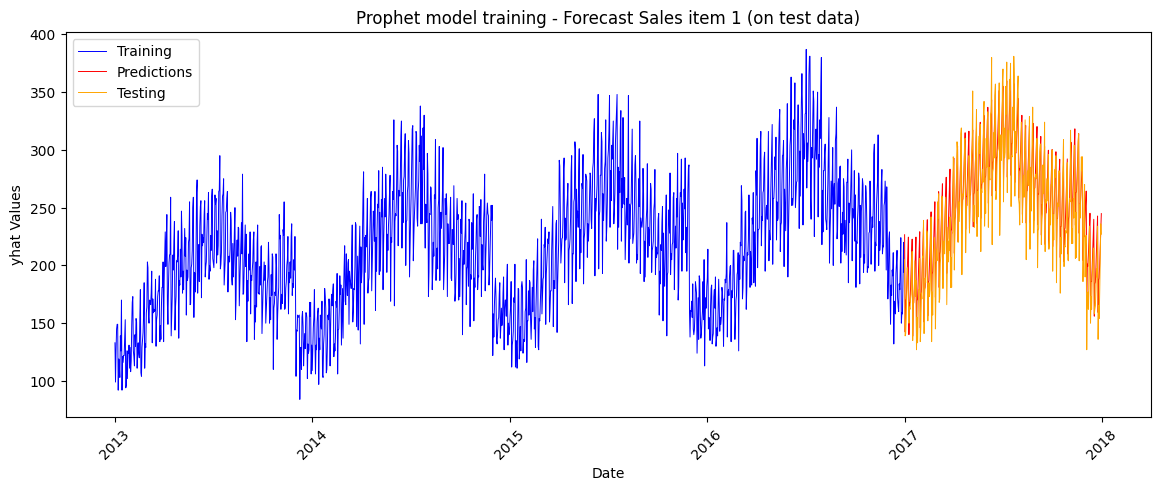

In [34]:
plt.figure(figsize=(14, 5))
plt.plot(train['ds'], train['y'], color ='b', linestyle='-', label='Training', linewidth=0.7)
plt.plot(forecast_test['ds'], forecast_test['yhat'], color='r', linestyle='-', label='Predictions', linewidth=0.7)
plt.plot(test['ds'], test['y'], color='orange', linestyle='-', label='Testing', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('yhat Values')
plt.xticks(rotation=45)
plt.legend()
plt.title('Prophet model training - Forecast Sales item 1 (on test data)')
plt.show()

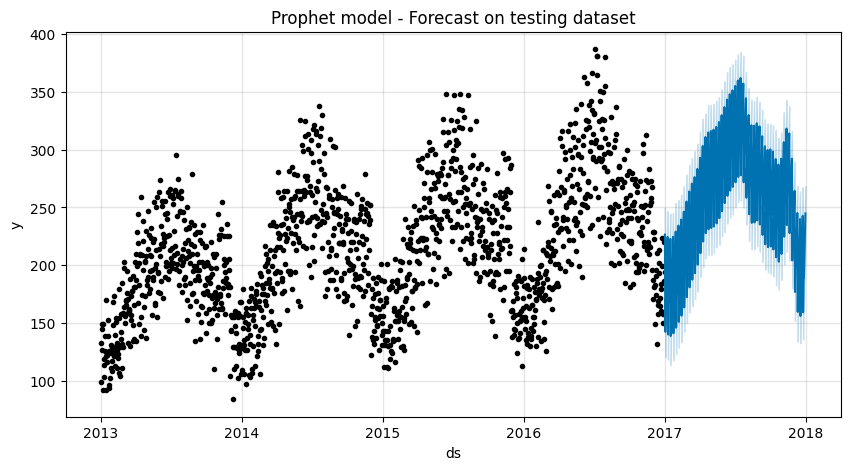

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = m_train.plot(forecast_test, ax=ax)
ax.set_title('Prophet model - Forecast on testing dataset')
plt.show()

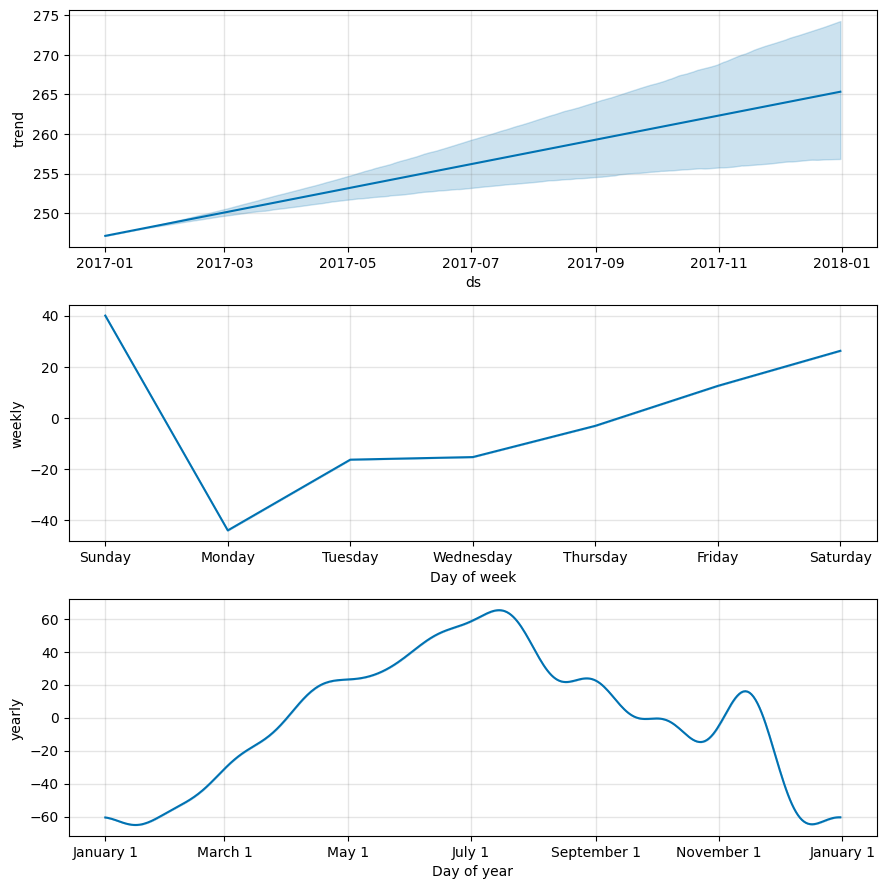

In [37]:
fig = m_train.plot_components(forecast_test)
plt.show()

In [38]:
comparison_df = pd.DataFrame({
    'predictions': forecast_test['yhat'].values,
    'testing': test['y'].values,
    'error': test['y'].values - forecast_test['yhat'].values
}, index=forecast_test['ds'])

comparison_df

,predictions,testing,error
ds,,,
2017-01-01,226.550687,205,-21.550687
2017-01-02,142.408007,139,-3.408007
2017-01-03,169.870727,141,-28.870727
2017-01-04,170.606366,155,-15.606366
2017-01-05,182.502318,175,-7.502318
...,...,...,...
2017-12-27,188.784529,154,-34.784529
2017-12-28,201.323363,178,-23.323363
2017-12-29,217.180337,207,-10.180337


In [43]:
error_mean = comparison_df['error'].mean()
error_std = comparison_df['error'].std()
print("Mean of Prophet model prediction error:" , error_mean)
print("Standard deviation of Prophet model prediciton error:" , error_std)

Mean of Prophet model prediction error: -9.395069375387218
Standard deviation of Prophet model prediciton error: 17.698238334069114


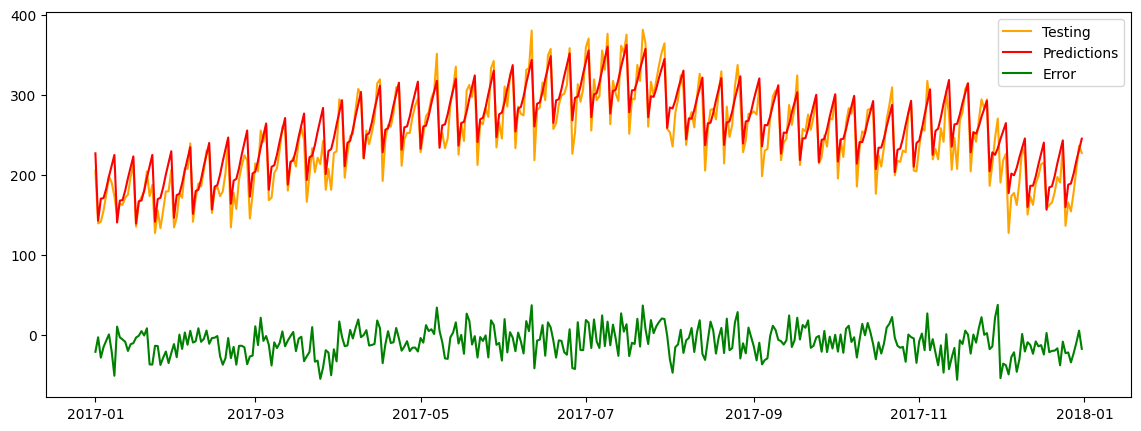

In [39]:
plt.figure(figsize=(14, 5))
plt.plot(comparison_df.index, comparison_df['testing'], color ='orange', linestyle='-', label='Testing')
plt.plot(comparison_df.index, comparison_df['predictions'], color='r', linestyle='-', label='Predictions')
plt.plot(comparison_df.index, comparison_df['error'], color='green', linestyle='-', label='Error')
plt.legend()
plt.show()

In [44]:
#Prophet model evaluation metrics

from sklearn.metrics import mean_absolute_error

# Calculate MAPE with handling NaN values
def calculate_mape(y_true, y_pred):
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    percentage_errors = np.zeros_like(y_true)
    non_zero_mask = (y_true != 0)
    
    percentage_errors[non_zero_mask] = np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])

    return np.mean(percentage_errors) * 100


# Calculate SMAPE with handling NaN values
def calculate_smape(y_true, y_pred):
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    percentage_errors = np.zeros_like(y_true)
    non_zero_mask = (y_true != 0)
    
    numerator = np.abs(y_true[non_zero_mask] - y_pred[non_zero_mask])
    denominator = (np.abs(y_true[non_zero_mask]) + np.abs(y_pred[non_zero_mask])) / 2
    
    percentage_errors[non_zero_mask] = numerator / denominator

    return np.mean(percentage_errors) * 100


from sklearn.metrics import mean_squared_error

# Assuming forecast_test is your forecasted values
mse = mean_squared_error(y_true=test['y'],
                         y_pred=forecast_test['yhat'])

rmse = np.sqrt(mean_squared_error(y_true=test['y'],
                                  y_pred=forecast_test['yhat']))

mae = mean_absolute_error(y_true=test['y'],
                          y_pred=forecast_test['yhat'])

mape = calculate_mape(y_true=test['y'], y_pred=forecast_test['yhat'])
smape = calculate_smape(y_true=test['y'], y_pred=forecast_test['yhat'])

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)
print("SMAPE:", smape)

MSE: 400.63681077968937
RMSE: 20.015913938156544
MAE: 16.173657828654754
MAPE: 0.0
SMAPE: 0.0


The m_train Prophet model works great with predicting 'y' (item 1 aggregate sales) from testing data.

We can appreciate that the prediction errors are very small (very small mean and standard deviation, so predictions don't differ that greatly from the actual values from the testing dataset). Also the evaluation metrics look good.

Let's now apply it to the full dataset of aggregate sales for item 1, so we can try and forecast item 1 aggregate daily sales for the next 90 days.

# 5) Applying the Prophet model (m_train) on the full df_train_agg_item1 dataset for forecasting item1 sales for the future 90 days

In [45]:
#Instantiating a new object, but KEEPING THE SAME MODEL ARCHITECTURE (as defined by our model evaluation)
model = Prophet()
model.fit(df_train_agg_item1)

14:58:27 - cmdstanpy - INFO - Chain [1] start processing
14:58:28 - cmdstanpy - INFO - Chain [1] done processing


In [48]:
print(df_test['date'].min())
print(df_test['date'].max())

2018-01-01 00:00:00
2018-03-31 00:00:00


In [50]:
df_test['date'].nunique()

90

The future dataframe will need to have 90 day, as we have 90 unique dates in df_test.

In [51]:
#Creating a future dataframe (so we can make forecasts 90 days into the future) 
future = pd.DataFrame({'ds': pd.date_range(start=df_train_agg_item1['ds'].max() + pd.Timedelta(days=1), periods=90, freq='D')})
future

,ds
0,2018-01-01
1,2018-01-02
2,2018-01-03
3,2018-01-04
4,2018-01-05
...,...
85,2018-03-27
86,2018-03-28
87,2018-03-29
88,2018-03-30


In [52]:
forecast90 = model.predict(future)
forecast90

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,252.215568,122.951578,165.772881,252.215568,252.215568,-107.013184,-107.013184,-107.013184,-45.373224,-45.373224,-45.373224,-61.639960,-61.639960,-61.639960,0.0,0.0,0.0,145.202384
1,2018-01-02,252.241139,151.164090,194.542624,252.241139,252.241139,-78.753229,-78.753229,-78.753229,-16.869230,-16.869230,-16.869230,-61.883999,-61.883999,-61.883999,0.0,0.0,0.0,173.487910
2,2018-01-03,252.266710,151.318069,195.640590,252.266710,252.266710,-77.774108,-77.774108,-77.774108,-15.560807,-15.560807,-15.560807,-62.213301,-62.213301,-62.213301,0.0,0.0,0.0,174.492602
3,2018-01-04,252.292281,165.428683,208.675742,252.292281,252.292281,-65.482122,-65.482122,-65.482122,-2.865414,-2.865414,-2.865414,-62.616708,-62.616708,-62.616708,0.0,0.0,0.0,186.810160
4,2018-01-05,252.317853,180.423852,224.118715,252.317853,252.317853,-50.400398,-50.400398,-50.400398,12.680452,12.680452,12.680452,-63.080850,-63.080850,-63.080850,0.0,0.0,0.0,201.917455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2018-03-27,254.389125,204.845919,249.293064,253.416857,255.254507,-26.612761,-26.612761,-26.612761,-16.869230,-16.869230,-16.869230,-9.743531,-9.743531,-9.743531,0.0,0.0,0.0,227.776364
86,2018-03-28,254.414696,207.526966,253.267325,253.430378,255.297123,-24.025954,-24.025954,-24.025954,-15.560807,-15.560807,-15.560807,-8.465146,-8.465146,-8.465146,0.0,0.0,0.0,230.388742
87,2018-03-29,254.440267,221.718287,267.204104,253.442118,255.343655,-9.980394,-9.980394,-9.980394,-2.865414,-2.865414,-2.865414,-7.114980,-7.114980,-7.114980,0.0,0.0,0.0,244.459874
88,2018-03-30,254.465839,237.720125,281.971206,253.455407,255.395018,6.982721,6.982721,6.982721,12.680452,12.680452,12.680452,-5.697731,-5.697731,-5.697731,0.0,0.0,0.0,261.448560


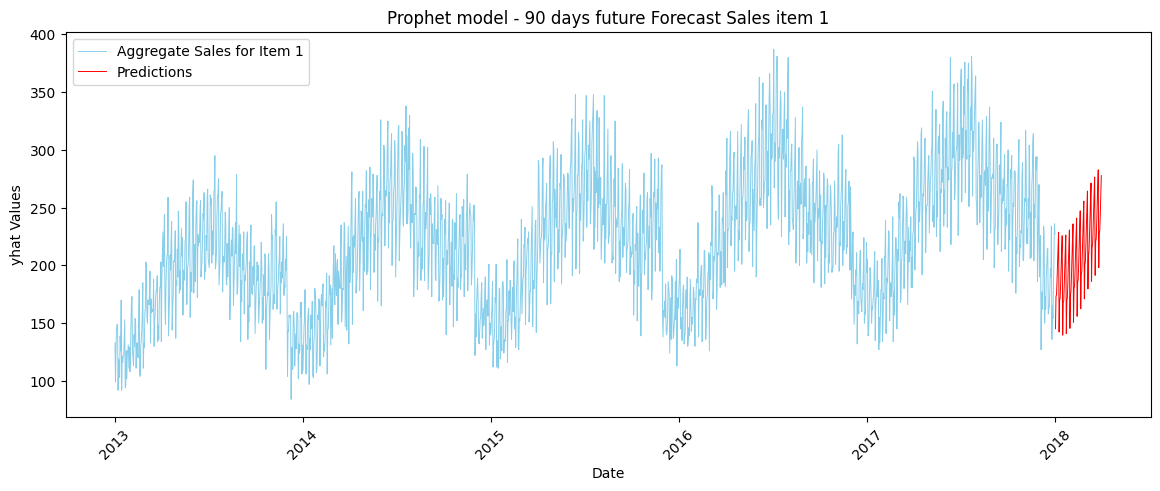

In [54]:
plt.figure(figsize=(14, 5))
plt.plot(df_train_agg_item1['ds'], df_train_agg_item1['y'], color ='skyblue', linestyle='-', label='Aggregate Sales for Item 1', linewidth=0.7)
plt.plot(forecast90['ds'], forecast90['yhat'], color='r', linestyle='-', label='Predictions', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('yhat Values')
plt.xticks(rotation=45)
plt.legend()
plt.title('Prophet model - 90 days future Forecast Sales item 1')
plt.show()

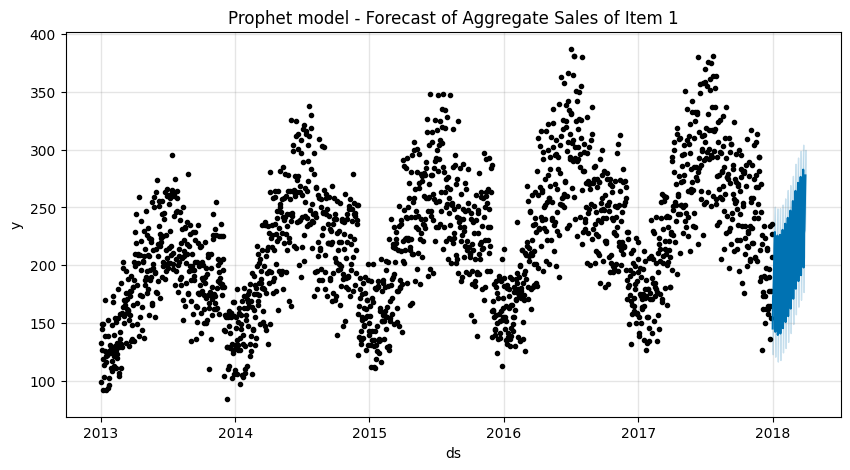

In [56]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(forecast90, ax=ax)
ax.set_title('Prophet model - Forecast of Aggregate Sales of Item 1')
plt.show()

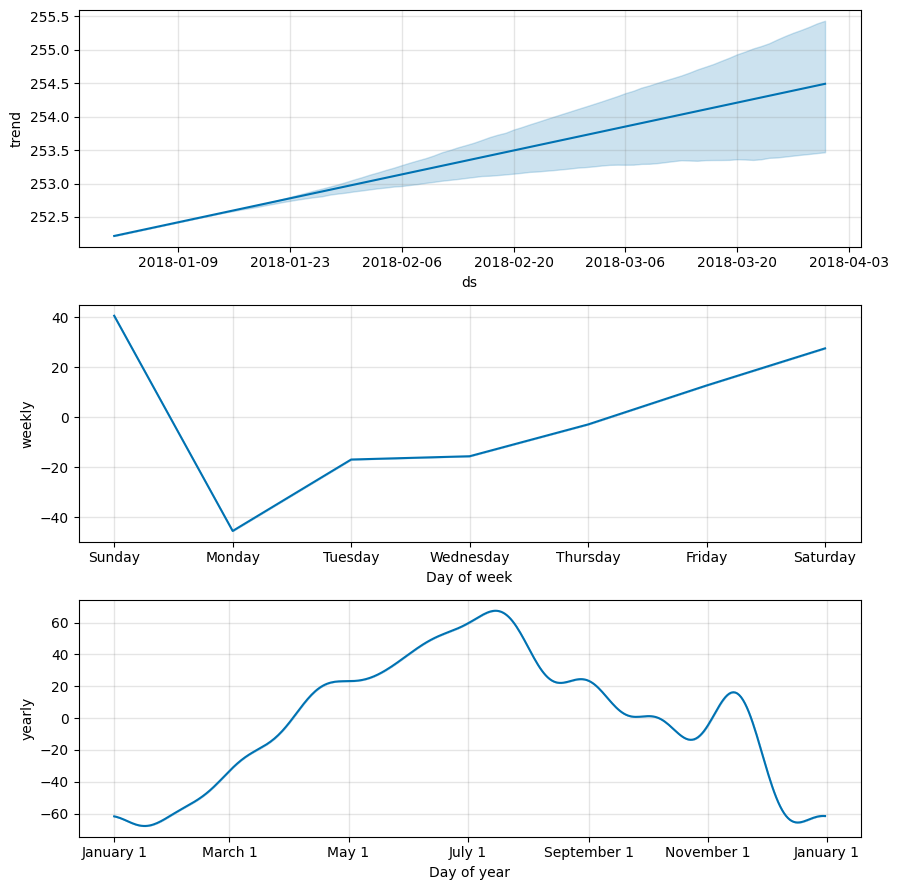

In [57]:
fig = model.plot_components(forecast90)
plt.show()

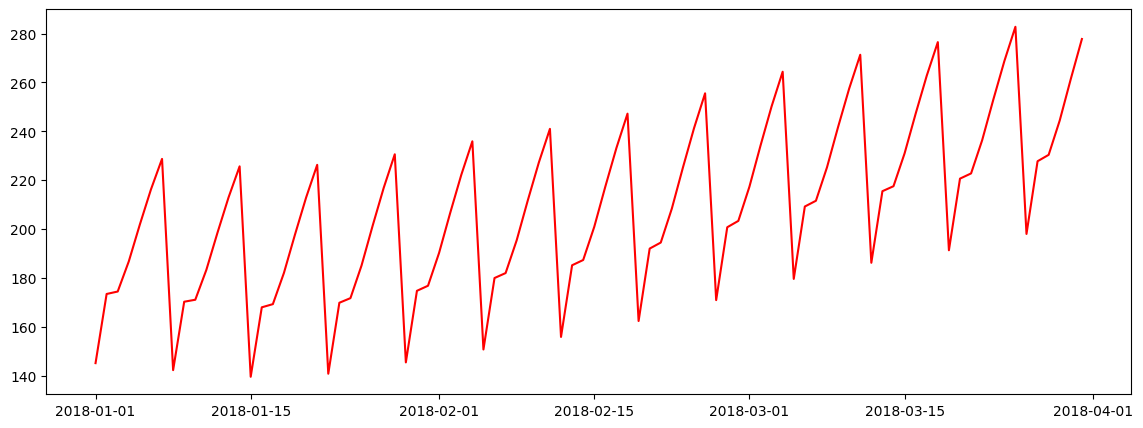

In [55]:
#Closeup of item1 aggregate daily sales over the future 90 days
plt.figure(figsize=(14, 5))
plt.plot(forecast90['ds'], forecast90['yhat'], color='r', linestyle='-', label='Predictions')
plt.show()

# 6) Using the Prophet model to produce daily item aggregate sales forecasts per different item

Creating two functions:

- **forecast_item** (it will run the Prophet model for a sub dataset of aggregate sales data related to the item, it will create forecasts 90 days into the future and also do relevant plots),

- **run_prophet_for_item** (it’ll take the item number we want to make predictions for, the relevant main dataset for aggregate sales data at item level, and then feed these into to the previously defined ‘forecast_item’ function).

In [60]:
def forecast_item(df_item, item_number):
    # Rename columns as expected by Prophet
    df_item = df_item.rename(columns={'date': 'ds', 'sales': 'y'})

    # Create a Prophet model
    model = Prophet(yearly_seasonality=True, daily_seasonality=True)

    # Fit the model
    model.fit(df_item)

    # Create a future dataframe for forecasting
    future = pd.DataFrame({'ds': pd.date_range(start=df_item['ds'].max() + pd.Timedelta(days=1), periods=90, freq='D')})

    # Make predictions
    forecast = model.predict(future)

    # Plot 1: Aggregate Sales and Predictions
    plt.figure(figsize=(14, 5))
    plt.plot(df_item['ds'], df_item['y'], color='b', linestyle='-', linewidth=0.5, label=f'Aggregate Sales for Item {item_number}')
    plt.plot(forecast['ds'], forecast['yhat'], color='r', linestyle='-', linewidth=0.5, label='Predictions')
    plt.xlabel('Date')
    plt.ylabel('yhat Values')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(f'Prophet model - 90 days future Forecast Sales item {item_number}')
    plt.show()

    # Plot 2: Predictions only
    plt.figure(figsize=(14, 5))
    plt.plot(forecast['ds'], forecast['yhat'], color='r', linestyle='-', label='Predictions')
    plt.xlabel('Date')
    plt.ylabel('yhat Values')
    plt.title(f'Prophet model - 90 days future Forecast Sales item {item_number}')
    plt.show()

    # Plot 3: Components plot
    fig = model.plot_components(forecast)
    plt.title(f'Prophet model - Forecast of Aggregate Sales of Item {item_number}')
    plt.show()

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

def run_prophet_for_item(item_number, df_train_agg_item):
    item_df = df_train_agg_item[df_train_agg_item['item'] == item_number]
    item_forecast = forecast_item(item_df, item_number)
    return item_forecast


Example 1: 90 days-ahead aggregate daily sales forecasts for **item 5**

15:11:01 - cmdstanpy - INFO - Chain [1] start processing
15:11:01 - cmdstanpy - INFO - Chain [1] done processing


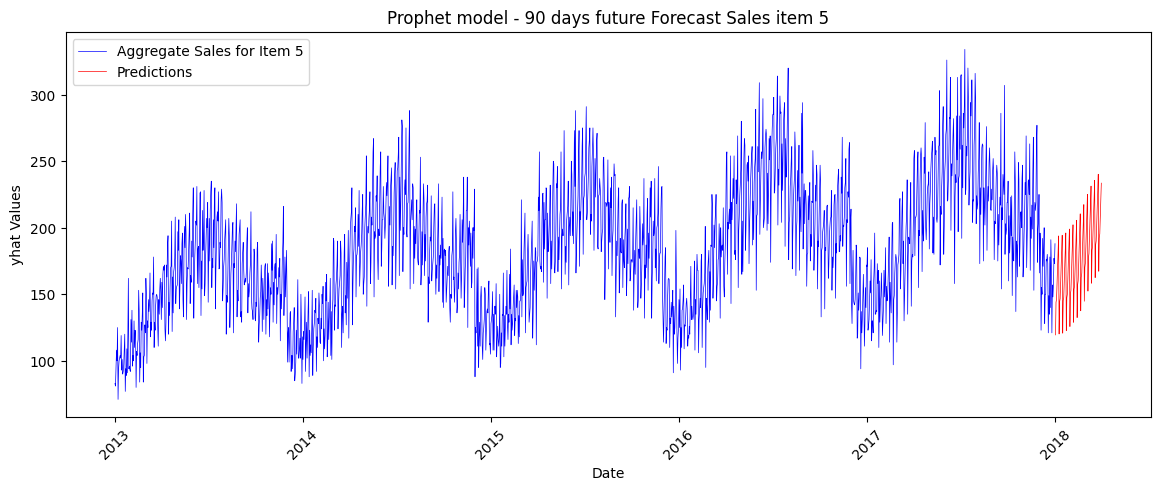

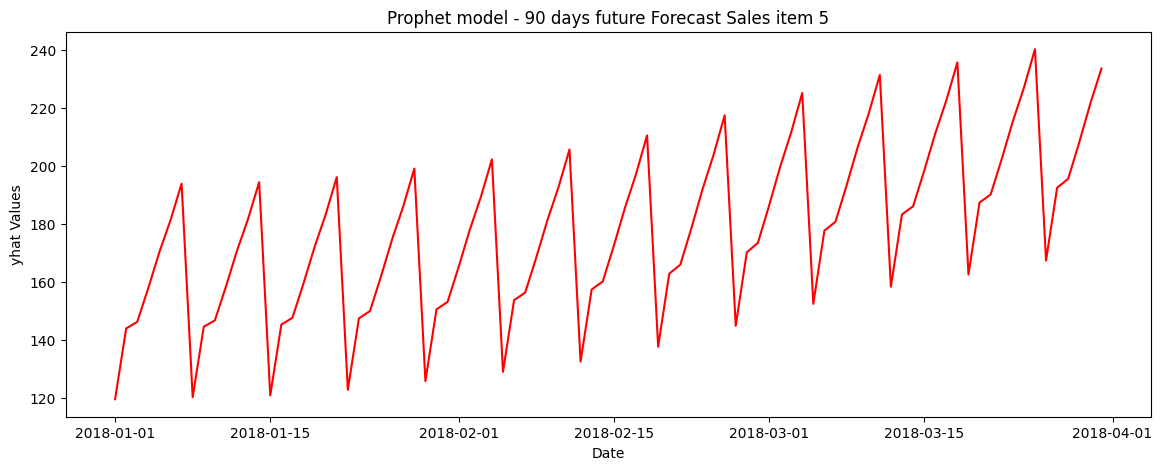

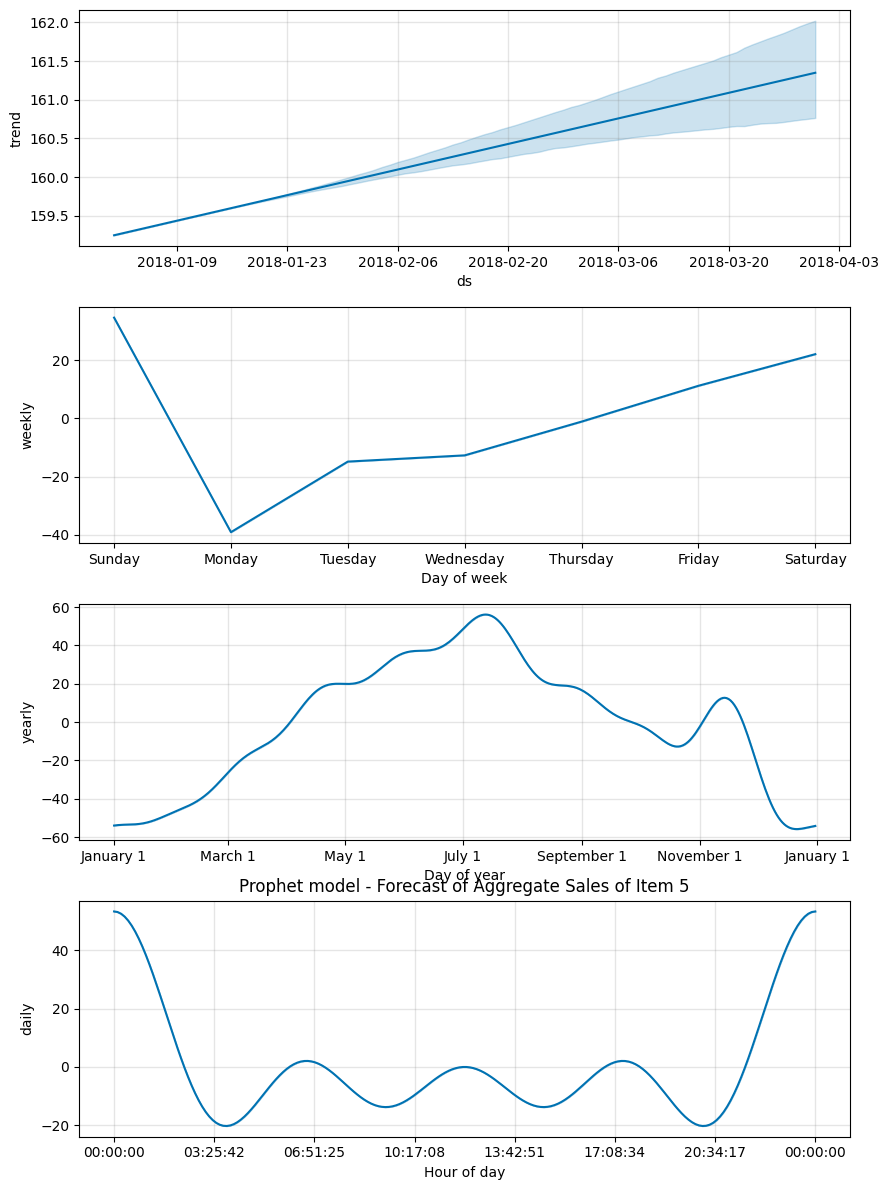

In [61]:
#If we would like to see sales forecasts 90 days into the future for item 5:
item_5_forecast = run_prophet_for_item(5, df_train_agg_item)

We can define another fucntion, called **get_item_forecast_dataframe**, so we can print the actual list of future forecasts

In [58]:
#Function 'get_item_forecast_dataframe' that will return a dataframe with the 90 days sales predictions per item

def get_item_forecast_dataframe(item_number, df_train_agg_item):
    item_df = df_train_agg_item[df_train_agg_item['item'] == item_number].copy()

    # Rename columns as expected by Prophet
    item_df = item_df.rename(columns={'date': 'ds', 'sales': 'y'})

    # Create a Prophet model
    model = Prophet(yearly_seasonality=True, daily_seasonality=True)

    # Fit the model
    model.fit(item_df)

    # Create a future dataframe for forecasting
    future = pd.DataFrame({'ds': pd.date_range(start=item_df['ds'].max() + pd.Timedelta(days=1), periods=90, freq='D')})

    # Make predictions
    forecast = model.predict(future)

    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [59]:
#Let’s for instance ask for a dataframe with all forecasts for item 5 (top-selling product):

forecast_item5 = get_item_forecast_dataframe(5, df_train_agg_item)
forecast_item5

15:08:50 - cmdstanpy - INFO - Chain [1] start processing
15:08:51 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01,119.476151,99.502831,139.354524
1,2018-01-02,143.887493,124.136032,164.189943
2,2018-01-03,146.163773,127.514481,166.889355
3,2018-01-04,157.868502,138.161912,177.233243
4,2018-01-05,170.272409,151.082513,189.879225
...,...,...,...,...
85,2018-03-27,192.414511,173.542233,213.043678
86,2018-03-28,195.504450,174.431768,214.683678
87,2018-03-29,208.109906,188.968199,227.953789
88,2018-03-30,221.498038,201.367679,242.803269


Example 1: 90 days-ahead aggregate daily sales forecasts for **item 15** (which wa sthe top-selling item according to past data)

15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing


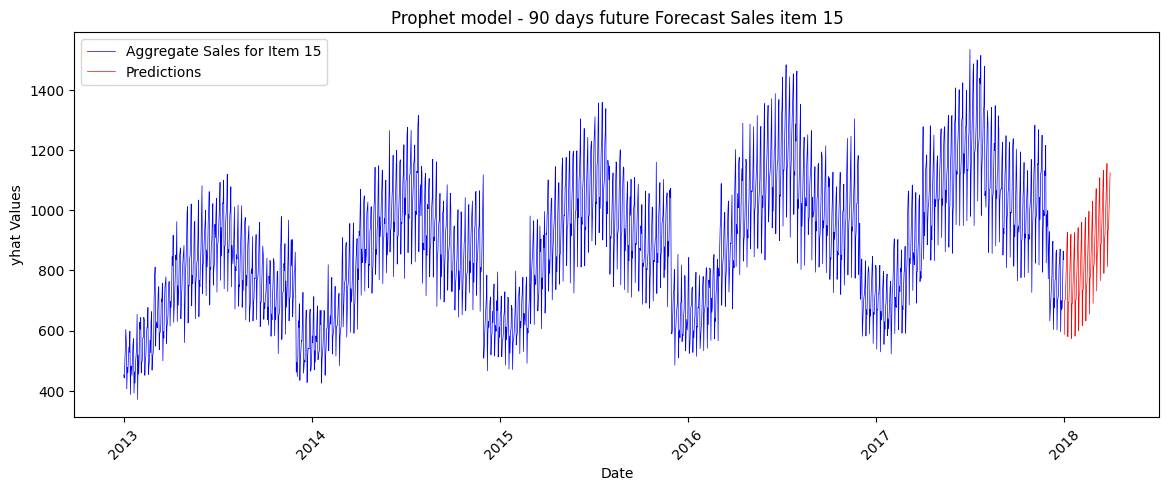

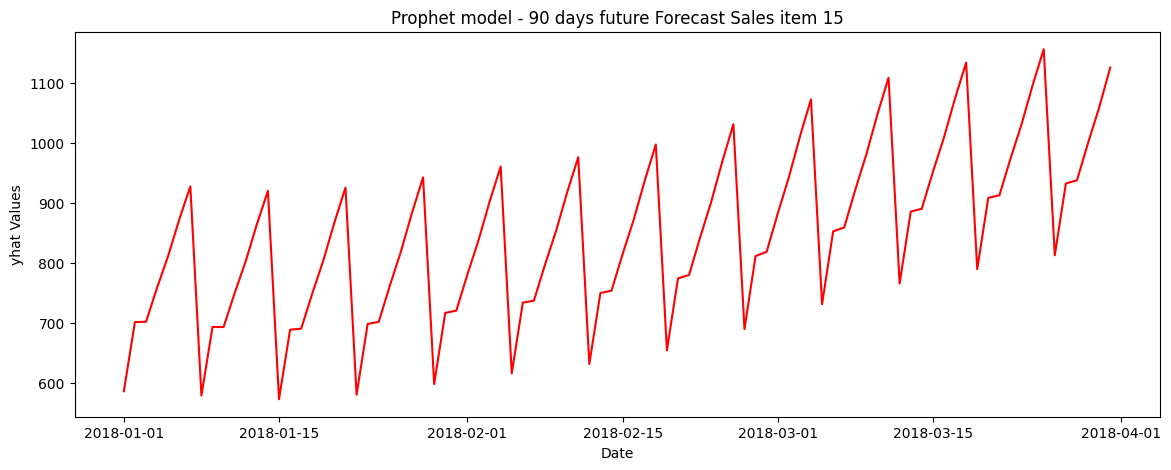

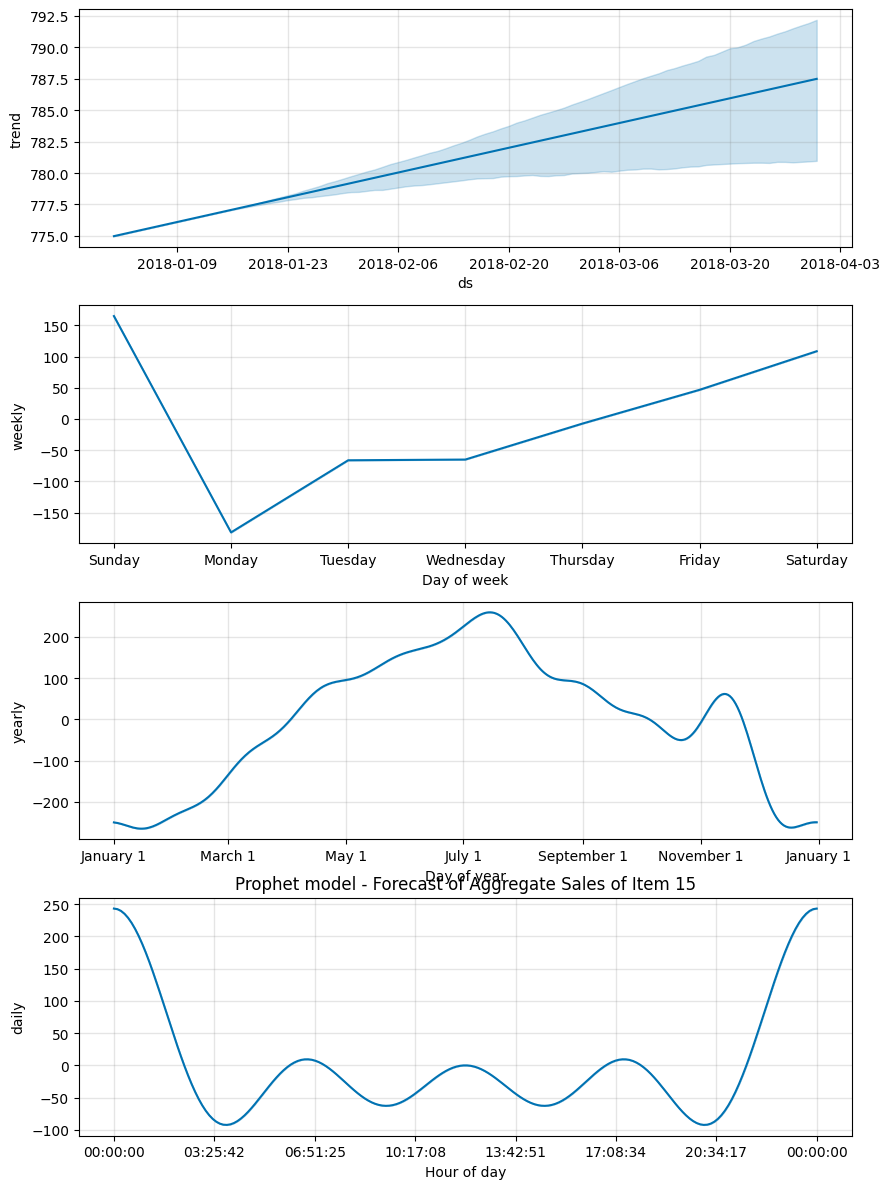

In [62]:
#90 days sales forecast for item 15
item_15_forecast = run_prophet_for_item(15, df_train_agg_item)

In [63]:
#Printing the forecasts list for item 15
forecast_item5 = get_item_forecast_dataframe(5, df_train_agg_item)
forecast_item5

15:15:39 - cmdstanpy - INFO - Chain [1] start processing
15:15:39 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01,119.476151,100.767904,138.806456
1,2018-01-02,143.887493,123.273258,162.131856
2,2018-01-03,146.163773,127.913496,165.959230
3,2018-01-04,157.868502,136.568241,176.790176
4,2018-01-05,170.272409,150.645259,189.896368
...,...,...,...,...
85,2018-03-27,192.414511,170.984949,210.825357
86,2018-03-28,195.504450,175.746193,215.211637
87,2018-03-29,208.109906,187.530351,226.588737
88,2018-03-30,221.498038,201.070414,241.467730


# 7) Inventory metrics using aggregate sales forecasts

**Max daily units sold per item**

In [64]:
#From the ‘df_train_agg_item’ dataset (aggregate sales per item through time), group by 'date' and 'item' and calculate the maximum units sold for each item on each day
max_units_per_item_per_day = df_train_agg_item.groupby(['date', 'item'])['sales'].max()

#Overall maximum units sold for each item
overall_max_units_per_item = max_units_per_item_per_day.groupby('item').max()

# Display the results
print("Maximum number of units sold per item in a day:")
print(overall_max_units_per_item)

Maximum number of units sold per item in a day:
item
1      387
2     1023
3      662
4      397
5      334
6     1033
7     1018
8     1392
9      897
10    1257
11    1222
12    1241
13    1475
14    1054
15    1535
16     485
17     576
18    1519
19     724
20     827
21     745
22    1387
23     522
24    1177
25    1409
26     858
27     404
28    1573
29    1213
30     749
31    1051
32     792
33    1256
34     474
35    1188
36    1348
37     513
38    1456
39     811
40     528
41     417
42     644
43     889
44     548
45    1407
46    1041
47     412
48     923
49     535
50    1187
Name: sales, dtype: int64





**Average units sold per day for each item**

In [65]:
#From the ‘df_train_agg_item’ dataset (aggregate sales per item through time), group by 'item' and calculate the average units sold per day for each item
average_daily_usage_per_item = df_train_agg_item.groupby('item')['sales'].mean()

# Display the results
print("Average daily usage per item:")
print(average_daily_usage_per_item)

Average daily usage per item:
item
1     219.815991
2     585.741512
3     366.422234
4     220.102410
5     183.587076
6     585.038883
7     585.310515
8     769.500548
9     513.898686
10    732.274370
11    696.563527
12    696.349398
13    843.165936
14    586.818729
15    880.307777
16    256.560789
17    329.948521
18    842.757941
19    403.555312
20    475.159365
21    403.170865
22    805.022453
23    292.978642
24    660.446331
25    806.864184
26    476.440854
27    220.497262
28    878.813253
29    696.188390
30    403.370208
31    586.443045
32    439.817634
33    695.609529
34    257.357612
35    658.018072
36    770.289157
37    292.583790
38    805.219058
39    438.834064
40    292.493976
41    220.021358
42    366.881161
43    512.943593
44    293.981928
45    805.841731
46    586.398686
47    220.033406
48    513.528478
49    293.353231
50    658.822015
Name: sales, dtype: float64


**Safety stock** calculation (assuming maximum and average lead time).

Safety stock = (Maximum number of units sold in a day×Maximum lead time for stock replenishment) − (Average daily usage×Average lead time in days)

In [66]:
#Assuming:

#14 days is the maximum period of time for an item to be ordered and eventually received)
max_lead_time = 14

#7 days in average for an item to be ordered and eventually received
avg_lead_time = 7 

In [67]:
# Calculate safety stock
safety_stock = (overall_max_units_per_item * max_lead_time) - (average_daily_usage_per_item * avg_lead_time)

# Display the results
print("Safety stock per item:")
print(safety_stock)

Safety stock per item:
item
1      3879.288061
2     10221.809419
3      6703.044359
4      4017.283133
5      3390.890471
6     10366.727820
7     10154.826396
8     14101.496166
9      8960.709200
10    12472.079409
11    12232.055312
12    12499.554217
13    14747.838445
14    10648.268894
15    15327.845564
16     4994.074480
17     5754.360350
18    15366.694414
19     7311.112815
20     8251.884447
21     7607.803943
22    13782.842826
23     5257.149507
24    11854.875685
25    14077.950712
26     8676.914020
27     4112.519168
28    15870.307229
29    12108.681271
30     7662.408543
31    10608.898686
32     8009.276561
33    12714.733297
34     4834.496714
35    12025.873494
36    13479.975904
37     5133.913472
38    14747.466594
39     8282.161555
40     5344.542169
41     4297.850493
42     6447.831873
43     8855.394852
44     5614.126506
45    14057.107886
46    10469.209200
47     4227.766156
48     9327.300657
49     5436.527382
50    12006.245893
Name: sales, dtype: fl

We can also consider:


- **Lead Time Demand:** it is the total demand for a product during the lead time (time it takes from the initiation of an order until the goods are received). It represents the expected quantity of the product that will be sold during the time it takes to replenish the stock. It's calculated by multiplying the average daily demand by the lead time.

Formula -> 
Lead Time Demand = Average Daily Demand × Lead Time



- **Reorder point**: it represents the inventory level at which you should reorder to avoid stockouts during the lead time

Formula ->
Reorder Point = Lead Time Demand + Safety Stock


The idea is: now that we can use the ‘get_item_forecast_dataframe’ function to get 90 days sales predictions for every item, we would like to have metrics such as safety stock and reorder point per every item using their forecasts (which we can consider to be the future demand).

For instance, let's put it all together for item 5

In [68]:
forecast_item5

,ds,yhat,yhat_lower,yhat_upper
0,2018-01-01,119.476151,100.767904,138.806456
1,2018-01-02,143.887493,123.273258,162.131856
2,2018-01-03,146.163773,127.913496,165.959230
3,2018-01-04,157.868502,136.568241,176.790176
4,2018-01-05,170.272409,150.645259,189.896368
...,...,...,...,...
85,2018-03-27,192.414511,170.984949,210.825357
86,2018-03-28,195.504450,175.746193,215.211637
87,2018-03-29,208.109906,187.530351,226.588737
88,2018-03-30,221.498038,201.070414,241.467730


In [69]:
#Average future demand (being the average forecast sales) for the next 90 days for item5:
avg_daily_forecast_item5 = forecast_item5['yhat'].mean()
avg_daily_forecast_item5

178.05571014199603

In [71]:
#Safety stock (assuming average lead time is 7 days and maximum lead time is 14 days):
safety_stock_item5 = (overall_max_units_per_item[5] * max_lead_time) - (average_daily_usage_per_item[5] * avg_lead_time)
safety_stock_item5

3390.8904709748085

In [72]:
#Assuming again that average lead time is 7 days, we can calculate the Lead Time Demand for item5:
avg_lead_time = 7
lead_time_demand_item5 = avg_daily_forecast_item5 * avg_lead_time
lead_time_demand_item5

1246.3899709939722

In [73]:
#Calculating Reorder Point for item 5
reorder_point_item5 = lead_time_demand_item5 + safety_stock_item5 
reorder_point_item5 

4637.280441968781

We can again create a function called **calculate_inventory_metrics** to serve the inventory purposes.

For the function to produce results, we need:
- item number,
- average lead time (I manually put ‘7’, as we had previously assumed that),
- maximum lead time (I manually put ‘14’, as we had previously assumed that),
- overall_max_units_per_item (as previously defined - need to create this before running the function)
- average_daily_usage_per_item (as previously defined - need to create this before running the function).


In [74]:
#Function to calculate safety stock, lead time demand, reorder point for an item based on the 90 days sales forecasts

def calculate_inventory_metrics(item_number, forecast_df, avg_lead_time, max_lead_time, overall_max_units_per_item, average_daily_usage_per_item):
    # Calculate average daily forecast for the item
    avg_daily_forecast = forecast_df['yhat'].mean()

    # Calculate safety stock for the item
    safety_stock = (overall_max_units_per_item[item_number] * max_lead_time) - (average_daily_usage_per_item[item_number] * avg_lead_time)

    # Calculate lead time demand for the item
    lead_time_demand = avg_daily_forecast * avg_lead_time

    # Calculate reorder point for the item
    reorder_point = lead_time_demand + safety_stock

    # Print the results
    print(f"Item {item_number} - Average Daily Forecast: {avg_daily_forecast}")
    print(f"Item {item_number} - Safety Stock: {safety_stock}")
    print(f"Item {item_number} - Lead Time Demand: {lead_time_demand}")
    print(f"Item {item_number} - Reorder Point: {reorder_point}")

In [75]:
#Example of inventory metrics for item 5
calculate_inventory_metrics(5, forecast_item5, 7, 14, overall_max_units_per_item, average_daily_usage_per_item)

Item 5 - Average Daily Forecast: 178.05571014199603
Item 5 - Safety Stock: 3390.8904709748085
Item 5 - Lead Time Demand: 1246.3899709939722
Item 5 - Reorder Point: 4637.280441968781


In [76]:
#If we would need inventory metrics let's say for item 8, we first need to generate the 90 days-ahead forecasts

forecast_item8 = get_item_forecast_dataframe(8, df_train_agg_item)

15:31:03 - cmdstanpy - INFO - Chain [1] start processing
15:31:04 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
calculate_inventory_metrics(8, forecast_item8, 7, 14, overall_max_units_per_item, average_daily_usage_per_item)

Item 8 - Average Daily Forecast: 745.5743786625578
Item 8 - Safety Stock: 14101.496166484118
Item 8 - Lead Time Demand: 5219.0206506379045
Item 8 - Reorder Point: 19320.51681712202
